[<- back to main page](implementation.ipynb)

# Example 1: Circular scalings in 2d

As our first example we consider a two-dimensional example, namely $\Omega:=\mathbb R^2\setminus B_{R}(\mathbf x_0)$, $\Gamma:=\partial B_1(0)$, for some center $\mathbf x_0\in B_1(0)$ and radius $R$ such that $R<1-\|\mathbf x_0\|$, and polar coordinates (cf. [Remark 3.3](dissertation_wess.pdf#thm.3.3))
\begin{align}\xi(\mathbf x)&:=\|\mathbf x\|-1,&
\hat x(\mathbf x)&:=\frac{\mathbf x}{\|\mathbf x\|}.\end{align}

We create the according mesh and set some parameters.

In [1]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
from numpy import array,sqrt,loadtxt
from matplotlib.pyplot import plot,show,xlim,ylim,legend


N = 25         #infinite elements
maxh = 0.1     #mesh-size
sigma = 0.3+0.5j   #complex scaling paramter
order = 5      #fem order
shift = 5-0.5j      #shift for Arnoldi algorithm
center = (0.2,0)    #center of inner circle
R = 0.5            #radius of inner circle

#create geometry
geo = SplineGeometry()
geo.AddCircle((0,0),1,leftdomain=1,rightdomain=0,bc='Gamma')
geo.AddCircle(center,R,leftdomain=0,rightdomain=1,bc='inner')


#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': N…

The weak formulation after a re-scaling of the solution and testfunction in the exterior is given by [(7.11)](dissertation_wess.pdf#equation.7.2.11).

For this first simple example we choose a frequency independent scaling
$$\sigma(\omega):=\sigma_0\in\mathbb C.$$

We start by creating the large finite element space for implementing our [tensor-product method](tp_disc.ipynb).

In [2]:
Gamma = mesh.Boundaries('Gamma')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)

fes = ProductSpace(fes_int,*( N*[fes_surf]) )

We import the necessary [infinte element matrices](infinite_elements.ipynb) and prepare the radial matrices:

In [3]:
from infinite_elements import *

ie_mass,ie_laplace,__,ie_mass_x,ie_mass_xx,ie_laplace_x,ie_laplace_xx,_ = ie_matrices(N)

S_ie_1 = 1/sigma*ie_laplace+2*ie_laplace_x+sigma*ie_laplace_xx-sigma/4*ie_mass
S_ie_1[0,0]-=1/2

S_ie_2 = sigma*ie_mass

M_ie = sigma * (ie_mass+2*sigma*ie_mass_x+sigma**2*ie_mass_xx)

Now we can assemble our bilinear forms.

In [4]:
ds_g = ds(definedon=Gamma)
p,q = fes.TnT()
p_int,q_int = p[0],q[0]
S = BilinearForm(
    grad(p_int)*grad(q_int)*dx
    +sum(S_ie_1[i,j]*p[j]*q[i]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(S_ie_1[i,j])>0)
    +sum(S_ie_2[i,j]*p[j].Trace().Deriv()*q[i].Trace().Deriv()*ds_g
       for i in range(N+1) for j in range(N+1) if abs(S_ie_2[i,j])>0)   
    ,symmetric=True).Assemble()

M = BilinearForm(
    -p_int*q_int*dx
    -sum(M_ie[i,j]*p[j]*q[i]*ds_g
       for i in range(N+1) for j in range(N+1) if abs(M_ie[i,j])>0)
    ,symmetric=True).Assemble()


Finally, we solve the resulting eigenvalue problem.

initialized PolyArnoldi for EVP of order 1 with 19990 dofs
called CalcInverse
inverting P(shift)
inverted in 0.5853931389974605 seconds
building Krylow space of dimension 200
starting iteration
Krylowspace built in 6.740196474002005 seconds
called SolveHessenberg
solved Hessenberg EVP in 0.328324636000616 seconds
calculating 80 big vectors


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

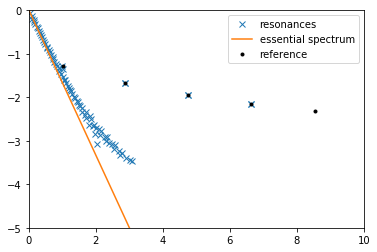

In [5]:
gf = GridFunction(fes,multidim=80)

#lam = sqrt(array(ArnoldiSolver(S.mat,M.mat,freedofs=fes.FreeDofs(),vecs=gf.vecs,shift=shift**2)))
lam = sqrt(array(PolyArnoldiSolver([S.mat,M.mat],shift**2,200,nevals=80,vecs=gf.vecs,inversetype='sparsecholesky',freedofs=fes.FreeDofs())))


plot(lam.real,lam.imag,'x',label='resonances')
plot([0,5*(1/sigma).real],[0,5*(1/sigma).imag],label='essential spectrum')

#load reference resonances from file
loaded=loadtxt('dhankel_1_zeros.out')
ref=(loaded[:,0]+1j*loaded[:,1])/R

plot(ref.real,ref.imag,'.k',label='reference')

xlim((0,10))
ylim((-5,0))
legend()
Draw(gf.components[0])

[<- back to main page](implementation.ipynb)